# Data Exploration

Exploring the use of data transformation methods to extract dominant colours from an image

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 25/11/2025   | Martin | Created   | Exploring colour quantisation | 
| 30/12/2025   | Martin | Update   | Added some new methods: manual edges and superpixel grouping | 
| 06/01/2026   | Martin | Update   | Completed manual edge finding | 
| 07/01/2026   | Martin | Update   | Best method: superpixel + contour finding | 

# Content

* [Introduction](#introduction)
* [Finding Dominant Colours](#finding-dominant-colours)
* [Reducing Details](#reducing-details)
  - [Superpixel Segmentation](#superpixel-segmentation)
  - [Region Adjacency Graph (RAG) merging](#region-adjacency-graph-rag-merging)
* [Edge Finding](#edge-finding)
  - [Method 1: Finding Contours](#method-1-finding-contours)
  - [Method 2: Manually Finding Edges](#method-2-manually-finding-edges)

# Finding Dominant Colours

<u>Application Notes</u>

1. Specify the image channel (e.g RGB, BGR, HSV, ...)
2. Resize the image

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
img = cv2.imread("data/img1.jpg")
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

cv2.imshow('image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [2]:
# Use KMeans clustering to find most common colours
def dominant_colours(img_path, k=10):
  img = cv2.imread(f"data/{img_path}")
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Flatten the image
  pixel_list = img.reshape((img.shape[0] * img.shape[1], 3))

  # Fit the quantisation model
  clt = KMeans(n_clusters=k, n_init='auto')
  clt.fit(pixel_list)

  # Returns the dominant colours
  d_colours = clt.cluster_centers_.astype('uint8')

  # Reconstructs the image
  labels = clt.labels_
  new_colours = d_colours[labels]
  quantised_img = new_colours.reshape((img.shape[0], img.shape[1], 3))
  
  return img, quantised_img, d_colours

In [3]:
K = 10
IMG_PATH = 'img5.jpg'
original_img, quantised_img, d_colours = dominant_colours(IMG_PATH, k=K)

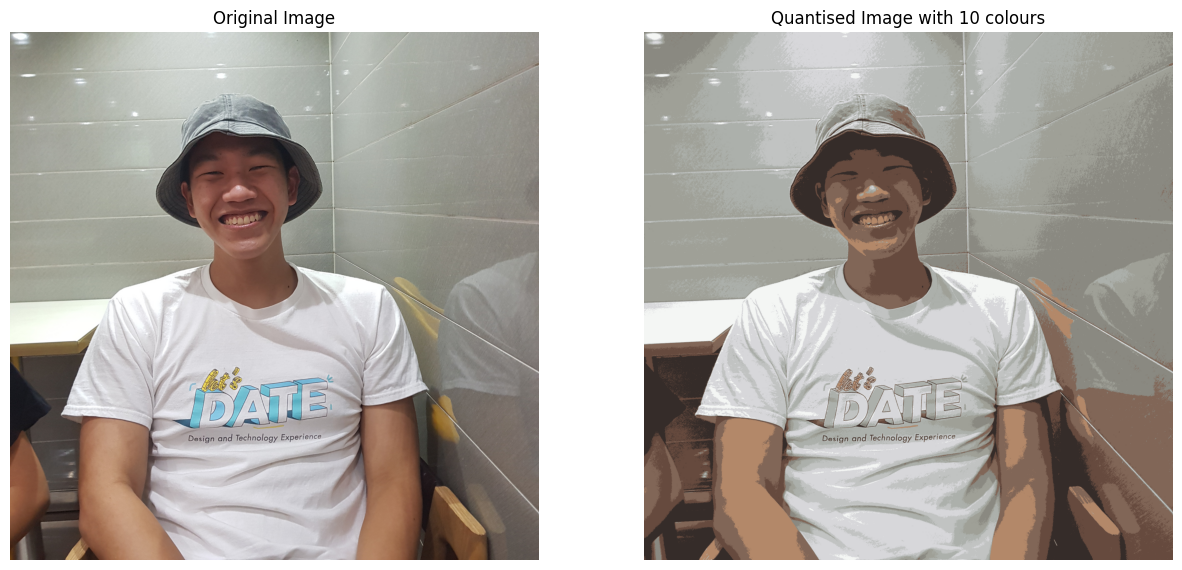

In [4]:
# Display results
plt.figure(figsize=(15, 12))

# Plot the original image
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Original Image')
plt.imshow(original_img)

# Plot the quantised image
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title(f'Quantised Image with {K} colours')
plt.imshow(quantised_img)

print()

plt.show()

---

# Reducing Details

Want to reduce details to make the edges more defined so the contours are more easily defined

## Superpixel segmentation

Superpixel segmentation is a technique used in image processing that divides an image into regions based on certain features to reduce the fidelity of the image while still preserving essential image features

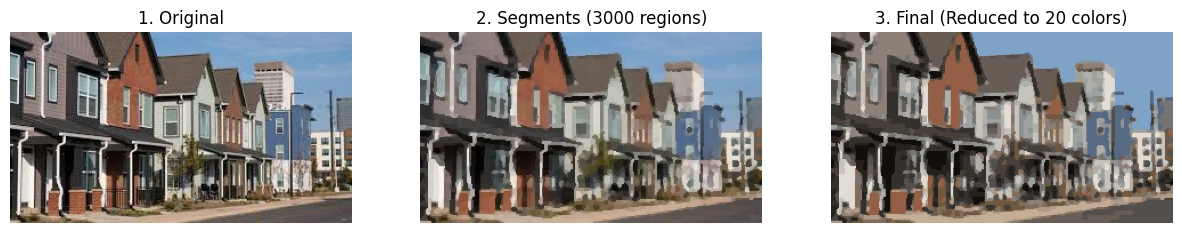

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.segmentation import slic
from skimage.color import label2rgb

def process_with_superpixels(image_path, n_segments=500, k_colors=10):
  # 1. Load Image
  img = cv2.imread(image_path)
  if img is None: 
    return
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
  # 2. Generate Superpixels (The "Edge First" Step)
  # n_segments: Approximate number of "puzzle pieces" you want
  segments = slic(img, n_segments=n_segments, compactness=10, sigma=1, start_label=1)
  
  # 3. Calculate Average Color for Each Segment
  # We create a new image where every pixel in a segment is replaced by that segment's average color
  superpixel_img = label2rgb(segments, img, kind='avg')
  
  # 4. Quantize to k_colors (The "Fill Color" Step)
  flat_img = superpixel_img.reshape((-1, 3))
  clt = KMeans(n_clusters=k_colors, n_init='auto')
  clt.fit(flat_img)
  
  # Reconstruct
  labels = clt.labels_
  centers = clt.cluster_centers_.astype("uint8")
  quantized_img = centers[labels].reshape(img.shape)
  
  # 5. Display
  plt.figure(figsize=(15, 5))
  
  plt.subplot(1, 3, 1)
  plt.title("1. Original")
  plt.axis('off')
  plt.imshow(img)
  
  plt.subplot(1, 3, 2)
  plt.title(f"2. Segments ({n_segments} regions)")
  plt.axis('off')
  plt.imshow(superpixel_img)
  
  plt.subplot(1, 3, 3)
  plt.title(f"3. Final (Reduced to {k_colors} colors)")
  plt.axis('off')
  plt.imshow(quantized_img)
  
  plt.show()

  return superpixel_img, quantized_img

# Run it
superpixel, sp_quant = process_with_superpixels('data/img3.jpeg', n_segments=3000, k_colors=20)

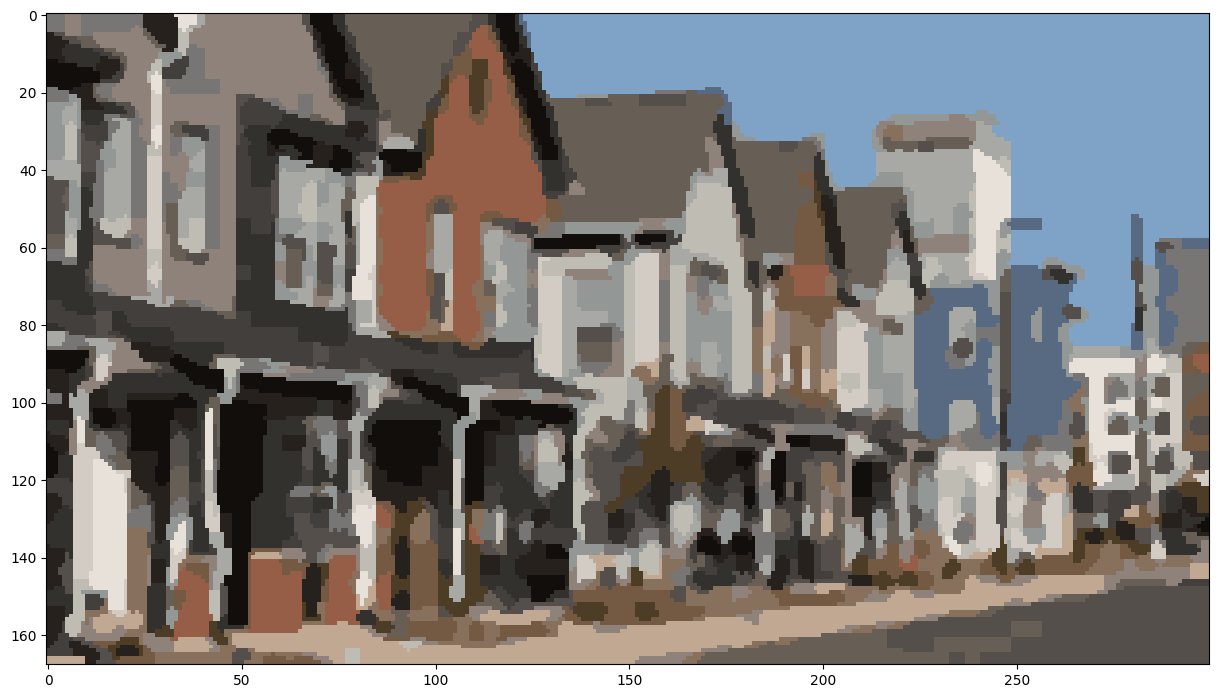

In [43]:
plt.figure(figsize=(15, 15))
plt.imshow(sp_quant)

## Region adjacency graph (RAG) merging

Region Adjacency Graph (RAG) and progressively merges regions that are similar in color. Merging two adjacent regions produces a new region with all the pixels from the merged regions. Regions are merged until no highly similar region pairs remain.

https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_rag_merge.html

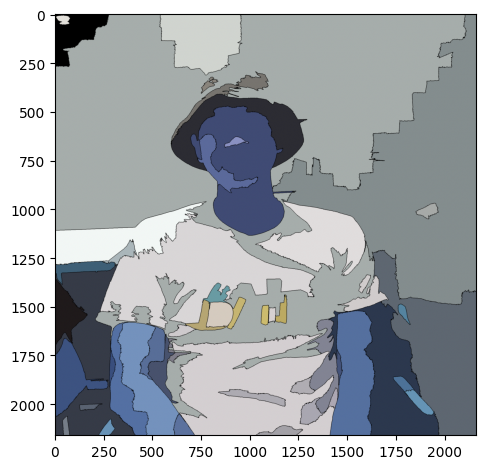

In [106]:
from skimage import data, segmentation, color
from skimage import graph
import numpy as np
import matplotlib.pyplot as plt


def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.
    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
      The graph under consideration.
    src, dst : int
      The vertices in `graph` to be merged.
    n : int
      A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
      A dictionary with the `"weight"` attribute set as the absolute
      difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.
    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
      The graph under consideration.
    src, dst : int
      The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (
        graph.nodes[dst]['total color'] / graph.nodes[dst]['pixel count']
    )


img = cv2.imread("./data/img5.jpg")
labels = segmentation.slic(img, compactness=10, n_segments=1000, start_label=1)
g = graph.rag_mean_color(img, labels)

labels2 = graph.merge_hierarchical(
  labels,
  g,
  thresh=50,
  rag_copy=False,
  in_place_merge=True,
  merge_func=merge_mean_color,
  weight_func=_weight_mean_color,
)

out = color.label2rgb(labels2, img, kind='avg', bg_label=0)
out = segmentation.mark_boundaries(out, labels2, (0, 0, 0))

fig, ax = plt.subplots()
ax.imshow(out)
plt.tight_layout()
plt.show()

- ✅: Detects colours (e.g yellow, light blue) that K-Means cannot because merges only happen between neighbours, meaning that certain regions where less common colours appear but are still grouped together are preserved
- ❌: Cannot select number of colours as output, only merge threshold and count threshold
- ❌: Feature preservation is hard to control

---

# Edge Finding

## Method 1: Finding Contours

In [ ]:
def generate_paint_by_numbers(img_path, k=10, min_area_threshold=200, source_encoding="RGB"):
  img = cv2.imread(img_path)

  if source_encoding == "BGR":
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
  # img = cv2.medianBlur(img, 7)
  shifted = cv2.pyrMeanShiftFiltering(img, sp=21, sr=51)

  # Flatten the image
  pixel_list = img.reshape((shifted.shape[0] * shifted.shape[1], 3))

  # Fit the quantisation model
  clt = KMeans(n_clusters=k, n_init='auto')
  clt.fit(pixel_list)

  # Returns the dominant colours
  d_colours = clt.cluster_centers_.astype('uint8')

  # Recreate the image
  labels = clt.labels_
  new_colours = d_colours[labels]
  quantised_img = new_colours.reshape((img.shape[0], img.shape[1], 3))

  # Create the PBN image
  labels_grid = labels.reshape(img.shape[:2])
  canvas = np.ones((img.shape[0], img.shape[1], 3), dtype='uint8') * 255

  for colour_id in range(K):
    # Binary mask - 255 if matches, 0 if not
    mask = np.where(labels_grid == colour_id, 255, 0).astype('uint8')

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
      # Filters out smaller areas
      if cv2.contourArea(contour) > min_area_threshold:
        # Draw the contours on the canvas
        cv2.drawContours(canvas, [contour], -1, (100, 100, 100), 1)

        # Find the center region for each cluster for each colour
        M = cv2.moments(contour)
        if M["m00"] != 0:
          center_X = int(M["m10"] / M["m00"])
          center_Y = int(M["m01"] / M["m00"])

          # Put label in the area
          cv2.putText(
            canvas,
            str(colour_id),
            (center_X, center_Y),
            cv2.FONT_HERSHEY_COMPLEX,
            0.8,
            (0, 0, 0),
            1
          )
  
  # Plot the entire image
  plt.figure(figsize=(20, 15))

  # Original Image
  plt.subplot(2, 2, 1)
  plt.axis('off')
  plt.title("Original Image")
  plt.imshow(img)

  # Original Image
  plt.subplot(2, 2, 2)
  plt.axis('off')
  plt.title("Quantised Image")
  plt.imshow(quantised_img)

  # PBN Image
  plt.subplot(2, 2, 3)
  plt.axis('off')
  plt.title("Paint By The Numbers")
  plt.imshow(canvas)

  # Colour palette
  plt.subplot(2, 2, 4)
  legend_height = 50 * k
  legend_img = np.zeros((legend_height, 200, 3), dtype='uint8') + 255

  for i, colour in enumerate(d_colours):
    cv2.rectangle(legend_img, (10, i*50+10), (60, i*50 + 40), colour.tolist(), -1)
    cv2.putText(
      legend_img,
      f"ID {i}",
      (70, i*50 + 35),
      cv2.FONT_HERSHEY_SIMPLEX, 
      0.5,
      (0, 0, 0),
      1
    )
  plt.imshow(legend_img)
  plt.show()

  return img, quantised_img, canvas

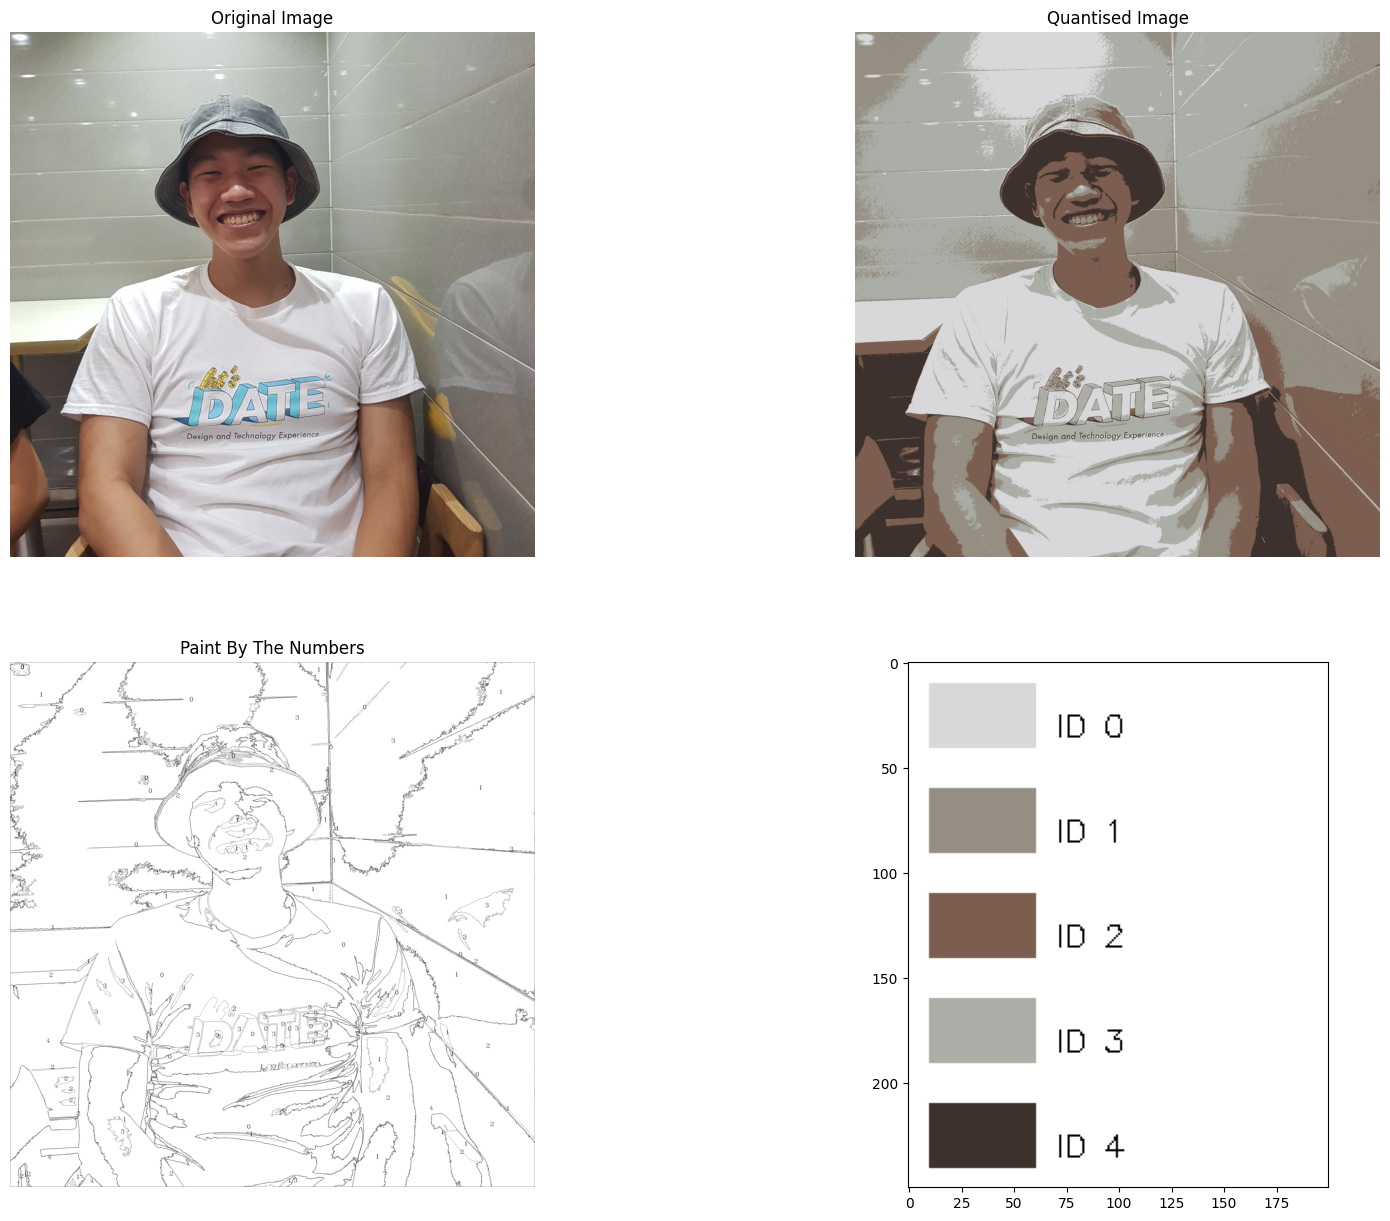

In [29]:
IMG_PATH = "data/img5.jpg"
K = 5

original_img, quantised_img, canvas = generate_paint_by_numbers(
  IMG_PATH,
  k=K,
  min_area_threshold=500,
  source_encoding="BGR"
)

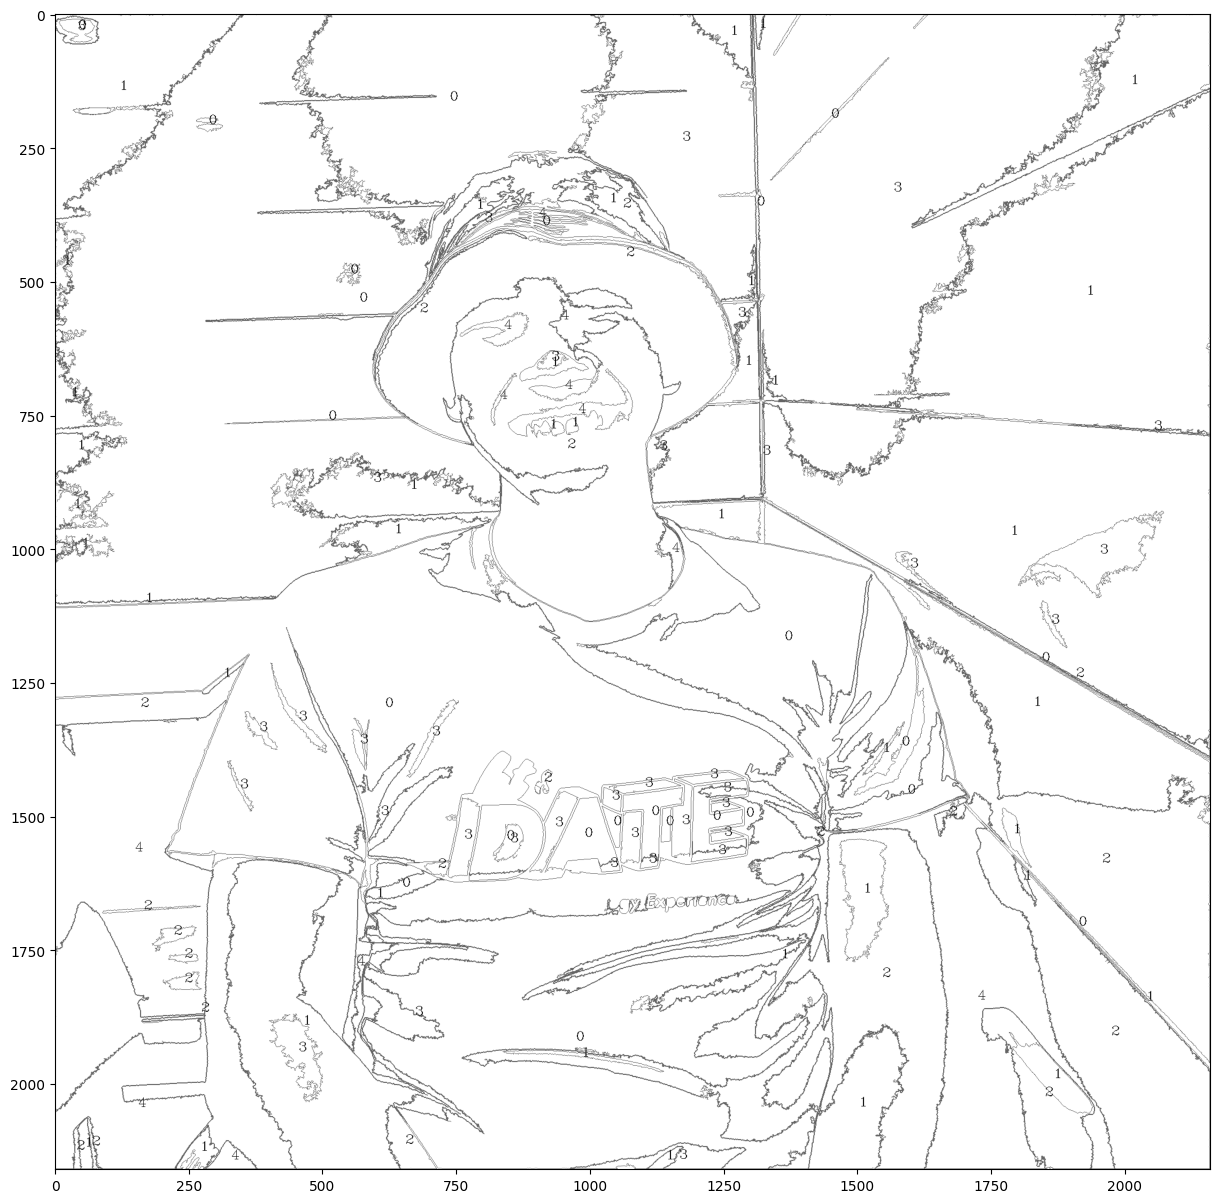

In [30]:
plt.figure(figsize=(15, 15))
plt.imshow(canvas)

In [111]:
def contours_superpixel(
  img_path,
  k=10,
  min_area_ratio=0.0005,
  # Superpixel configurations
  sp_n_segments=200,
  sp_compactness=10,
  sp_sigma=1,
):
  # 1. Load the image
  img = cv2.imread(img_path)
  if img is None:
    raise ValueError(f"No image found on path: {img_path}")

  # TODO: Add change image encoding method
  
  height, width, _ = img.shape

  # 2. Define scales for text details
  scale = max(height, width) / 1000.0
  font_scale = 0.6 * scale
  font_thickness = max(1, int(1 * scale))
  contour_thickness = max(1, int(1 * scale))

  # 3. Define the minimum threshold for colour areas
  # keeps only those areas which are `min_area_ratio`% of the entire image size
  min_area_threshold = int((height * width) * min_area_ratio)
  
  # 4. Run superpixel segmentation
  segments = slic(
    img,
    n_segments=sp_n_segments,
    compactness=sp_compactness,
    sigma=sp_sigma,
    start_label=1
  )
  superpixel_img = label2rgb(
    segments,
    img,
    kind='avg'
  )

  # 5. K-Means clustering of pixels
  pixel_list = superpixel_img.reshape(
    (superpixel_img.shape[0] * superpixel_img.shape[1], 3)
  )
  clt = KMeans(n_clusters=k, n_init='auto')
  clt.fit(pixel_list)

  d_colours = clt.cluster_centers_.astype('uint8') # found colours
  labels = clt.labels_ # index for each colour label
  new_colours = d_colours[labels] # extracted list of colours
  quantised_img = new_colours.reshape(
    (height, width, 3)
  )

  # 6. Create PBN canvas
  labels_grid = labels.reshape((height, width))
  canvas = np.ones((height, width, 3), dtype='uint8') * 255
  label_location_mask = np.zeros((height, width), dtype='uint8') # tracks location of text to prevent overlaps

  for colour_id in range(k):
    # Binary mask - 255 if matches, 0 if not
    mask = np.where(labels_grid == colour_id, 255, 0).astype('uint8')

    # Find the contours
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
      if cv2.contourArea(contour) > min_area_threshold:
        # Draw the contours on the canvas
        cv2.drawContours(canvas, [contour], -1, (150, 150, 150), contour_thickness)

        # Try the center region for each cluster for each colour
        M = cv2.moments(contour)
        if M["m00"] != 0:
          center_X = int(M["m10"] / M["m00"])
          center_Y = int(M["m01"] / M["m00"])
        else:
          center_X, center_Y = contour[0][0]

        # Check if point is within the contour
        # dist >0: inside, <0: outside, =0: on edge
        # if outside, find distance that is furthest from all contour boundaries
        if cv2.pointPolygonTest(contour, pt=(center_X, center_Y), measureDist=False) < 0:
          dist_mask = np.zeros((height, width), dtype='uint8')
          cv2.drawContours(dist_mask, [contour], -1, 255, -1)
          dist_transform = cv2.distanceTransform(
            dist_mask,
            distanceType=cv2.DIST_L2,
            maskSize=3
          )
          _, _, _, max_loc = cv2.minMaxLoc(dist_transform)
          center_X, center_Y = max_loc
        
        # Text settings
        current_font_scale = font_scale
        placed = False

        # trying 3 sizes of fonts scaled accordingly
        for s in [1.0, 0.7, 0.4]:
          temp_scale = current_font_scale * s
          text = str(colour_id)
          (text_width, text_height), _ = cv2.getTextSize(
            text,
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=temp_scale,
            thickness=font_thickness
          )

          text_x, text_y = center_X - (text_width // 2), center_Y + (text_height // 2)

          # boundary check
          if text_x < 0 or text_x + text_width >= width or text_y - text_height < 0 or text_y >= height:
            continue
          
          # overlap check
          roi = label_location_mask[text_y-text_height:text_y, text_x:text_x+text_height]
          if np.any(roi):
            continue

          # containment check
          corners = [(text_x, text_y), (text_x+text_width, text_y), (text_x, text_y-text_height), (text_x+text_width, text_y-text_height)]
          if all(cv2.pointPolygonTest(contour, pt, False) >= 0 for pt in corners):
            cv2.putText(
              canvas,
              text=text,
              org=(text_x, text_y),
              fontFace=cv2.FONT_HERSHEY_SIMPLEX,
              fontScale=temp_scale,
              color=(0, 0, 0),
              thickness=font_thickness
            )
            label_location_mask[text_y-text_height:text_y, text_x:text_x+text_width] = 255
            placed = True
            break
        
        # If still not placed, force into best spot with smallest font
        if not placed:
          small_scale = current_font_scale * 0.3
          cv2.putText(
            canvas,
            text=str(colour_id),
            org=(center_X, center_Y),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=small_scale,
            color=(50, 50, 50),
            thickness=1
          )
          
  # Plot the entire image
  plt.figure(figsize=(20, 15))

  # Original Image
  plt.subplot(2, 2, 1)
  plt.axis('off')
  plt.title("Original Image")
  plt.imshow(img)

  # Original Image
  plt.subplot(2, 2, 2)
  plt.axis('off')
  plt.title("Quantised Image")
  plt.imshow(quantised_img)

  # PBN Image
  plt.subplot(2, 2, 3)
  plt.axis('off')
  plt.title("Paint By The Numbers")
  plt.imshow(canvas)

  # Colour palette
  plt.subplot(2, 2, 4)
  legend_height = 50 * k
  legend_img = np.zeros((legend_height, 200, 3), dtype='uint8') + 255

  for i, colour in enumerate(d_colours):
    cv2.rectangle(legend_img, (10, i*50+10), (60, i*50 + 40), colour.tolist(), -1)
    cv2.putText(
      legend_img,
      f"ID {i}",
      (70, i*50 + 35),
      cv2.FONT_HERSHEY_SIMPLEX, 
      0.5,
      (0, 0, 0),
      1
    )
  plt.imshow(legend_img)
  plt.show()

  return img, quantised_img, canvas

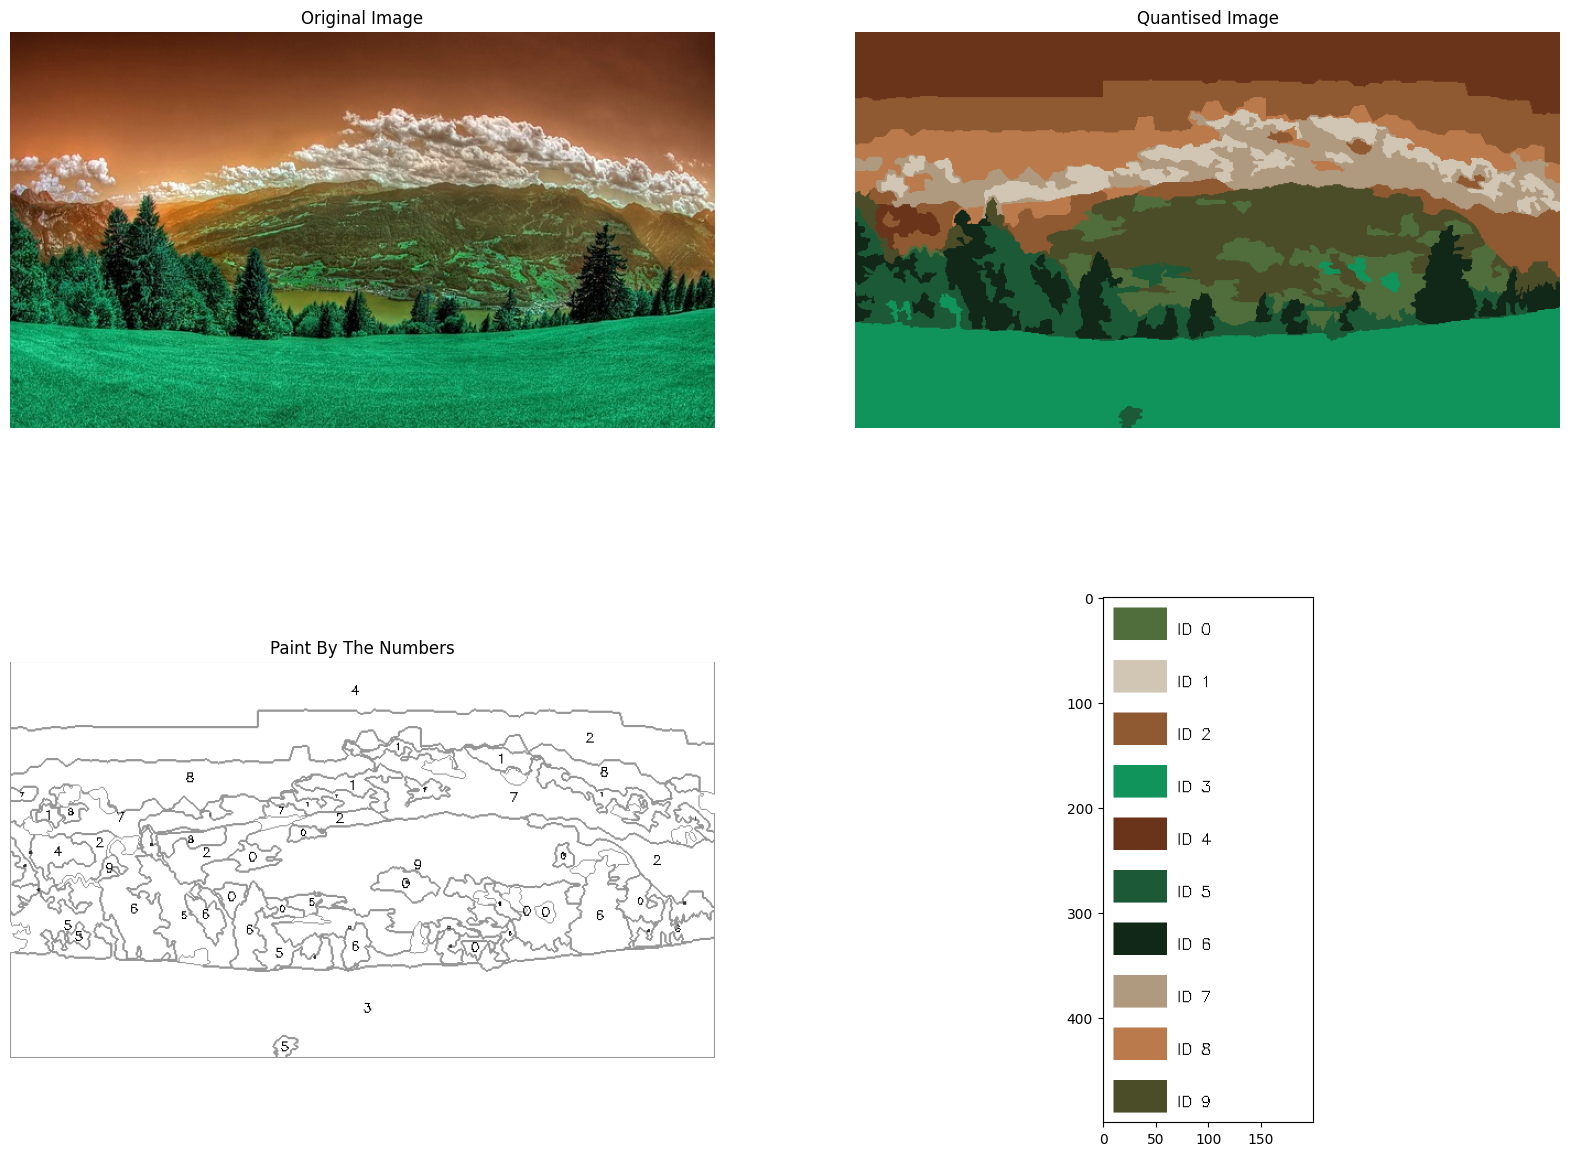

In [114]:
IMG_PATH = "data/img1.jpg"
K = 10

original_img, quantised_img, canvas = contours_superpixel(
  IMG_PATH,
  k=K,
  min_area_ratio=0.001,
  # Superpixel configurations
  sp_n_segments=1000,
  sp_compactness=10,
  sp_sigma=1,
)

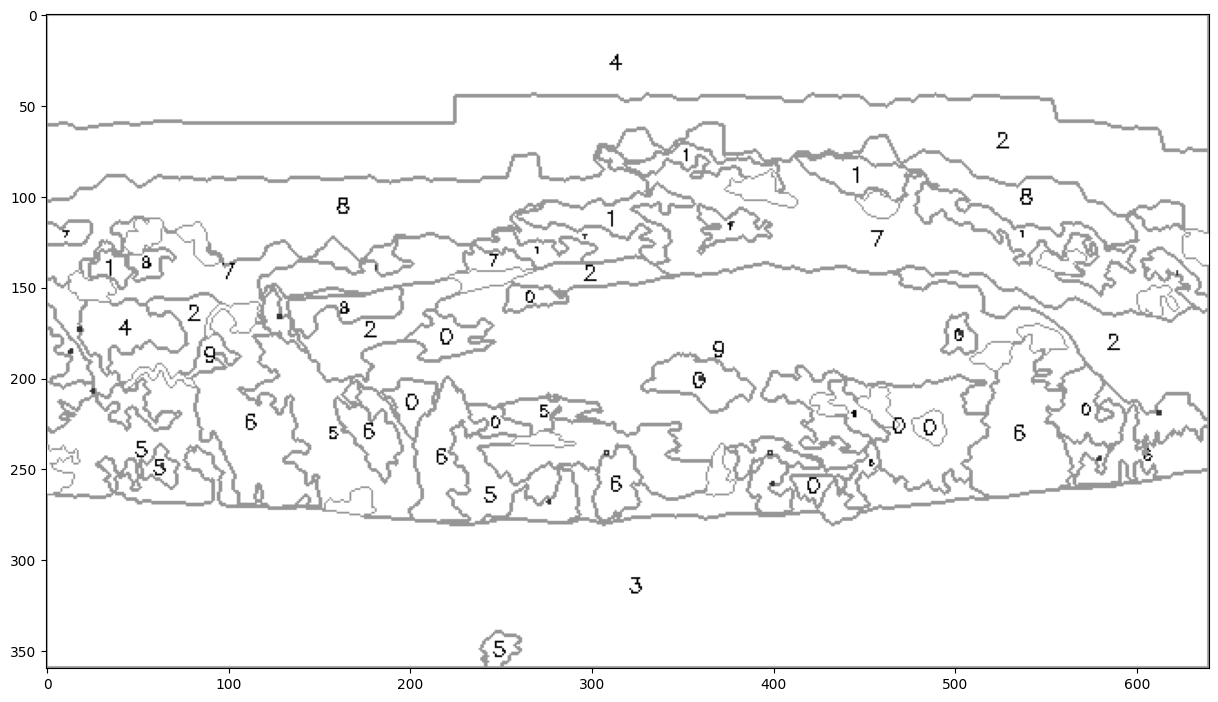

In [115]:
plt.figure(figsize=(15, 15))
plt.imshow(canvas)

## Method 2: Manually Finding Edges

Moving horizontally and vertically, change the pixel value to black if the colour changes

In [44]:
def manual_edges(img):
  # Create a mask of outline pixels
  mask = np.zeros([img.shape[0], img.shape[1]])
  outline = np.zeros([img.shape[0], img.shape[1], 3], dtype=np.uint8)

  # Horizontal move 
  prev_pixel = img[0][0]
  for j in range(img.shape[1]):
    for i in range(img.shape[0]):
      current_pixel = img[i][j]
      if not np.array_equal(prev_pixel, current_pixel):
        mask[i][j] = 1
      
      prev_pixel = current_pixel

  # Vertical move
  prev_pixel = img[0][0]
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      current_pixel = img[i][j]
      if not np.array_equal(prev_pixel, current_pixel):
        mask[i][j] = 1
      
      prev_pixel = current_pixel
  
  bool_mask = mask.astype(bool)
  outline[~bool_mask] = 255
  
  return outline

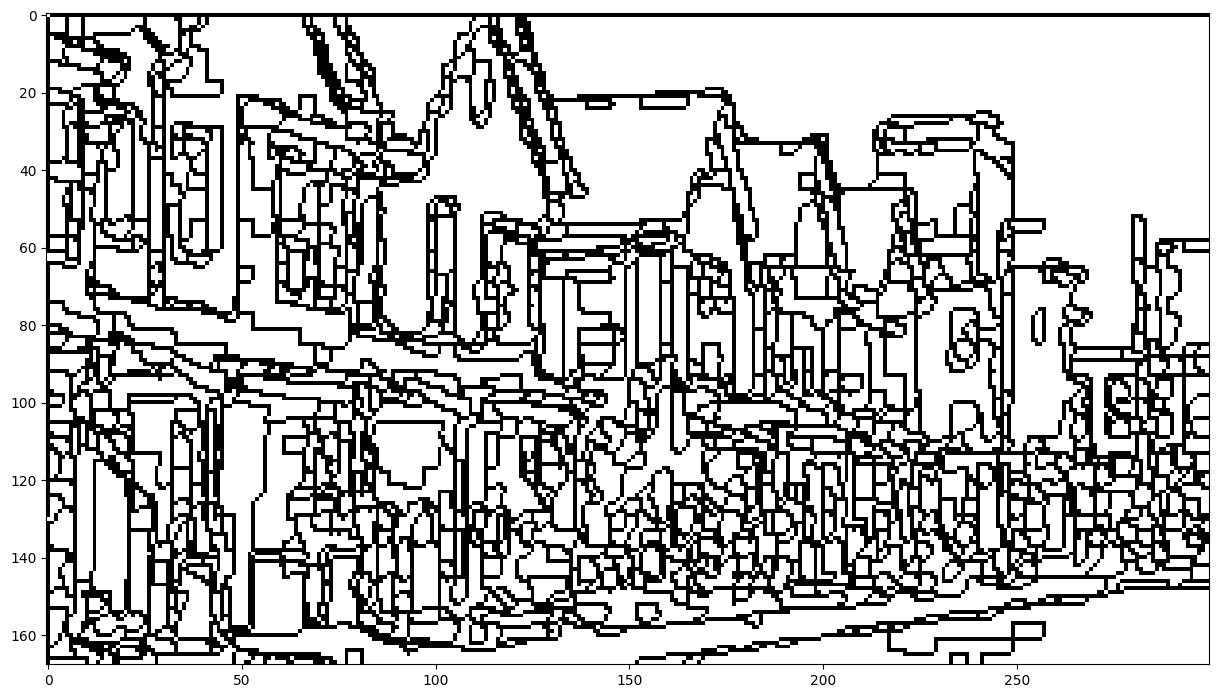

In [47]:
outline = manual_edges(sp_quant)

fig, ax = plt.subplots(figsize=(15, 15))
# ax.imshow(sp_quant, alpha=1)
ax.imshow(outline, alpha=1)
plt.show()

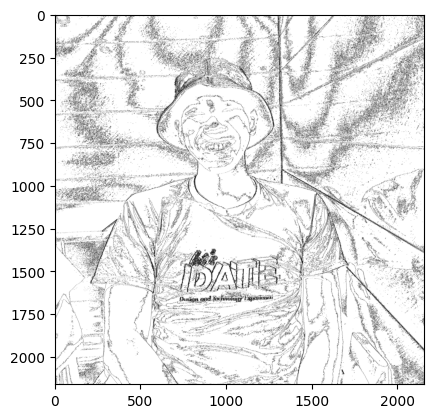

In [22]:
plt.imshow(pbn)

In [1]:
%load_ext watermark
%watermark

Last updated: 2026-01-06T21:38:03.857141+08:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 9.8.0

Compiler    : MSC v.1938 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 20
Architecture: 64bit

